# Introduction to single-cell multi-view profiler (scMVP)
In this introductory tutorial, we present the different tasks of a scMVP workflow
1. Loading the multi-omics data
2. Training the multi-view model
3. Retrieving the common latent space and imputed multi-omics values
4. Perform cell clustering and differential expression 
5. Visualize the common latent space and clustering with umap

In [1]:
%matplotlib inline

import sys
sys.path.append('/mnt/scMVP') 

import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scMVP.dataset import LoadData,GeneExpressionDataset, CellMeasurement
from scMVP.models import VAE_Attention, Multi_VAE_Attention, VAE_Peak_SelfAttention
from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer
import torch

import scanpy as sc
import anndata

import scipy.io as sp_io
from scipy.sparse import csr_matrix, issparse
print(os.getcwd())





[2025-05-13 05:17:20,765] INFO - scMVP._settings | Added StreamHandler with custom formatter to 'scMVP' logger.


/mnt/scMVP/demos


In [2]:
# If your PC do not have GPU, your can use multi threads to accelerate the training 
torch.set_num_threads(40) # do not use all CPU threads

## Step1: Loading data

 loading the sci-CAR cell line dataset described in Junyue Cao et al. (2018).

* Junyue Cao, et al. "Joint profiling of chromatin accessibility and gene 
expression in thousands of single cells." Science 361.6409 (2018): 1380-1385. 
<br>

You can also downloaded processed input in **README.md.**

In [5]:
input_path = "/mnt/sciCAR_cellline/"
output_path = "/mnt/appealing/sciCAR_cellline/scMVP_output"

sciCAR_cellline_dataset = {
                "gene_names": 'sciCAR_cellline_scale_gene.txt',
                "gene_expression": 'sciCAR_cellline_rna_normalize_count.mtx',
                "gene_barcodes": 'sciCAR_cellline_cell_barcode.txt',
                "atac_names": 'sciCAR_cellline_peak.txt',
                "atac_expression": 'sciCAR_cellline_atac_normalize_count.mtx',
                "atac_barcodes": 'sciCAR_cellline_cell_barcode.txt'
                }

dataset = LoadData(dataset=sciCAR_cellline_dataset,data_path=input_path,
                       dense=False,gzipped=False, atac_threshold=0.001,
                       cell_threshold=1)
print(dataset.nb_genes)


[2025-05-13 05:26:18,278] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2025-05-13 05:26:22,579] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2025-05-13 05:26:22,625] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2025-05-13 05:26:22,626] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2025-05-13 05:26:23,298] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2025-05-13 05:26:23,319] INFO - scMVP.dataset.dataset | Downsampled from 4316 to 4316 cells


3000


## Step2: train your scMVP model, and get trained output

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA (GPU required) 
* __n_centroids__: Set the number of cell types
* __n_alfa__: Set the weight of KL loss

In [5]:
import time
n_epochs = 10
lr = 1e-3
use_batches = False
use_cuda = True # False if using CPU
n_centroids = 5 
n_alfa = 1.0

start_time = time.time()
multi_vae = Multi_VAE_Attention(dataset.nb_genes, len(dataset.atac_names), n_batch=0, n_latent=20, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)
if os.path.exists("{}/multi_vae_trainer_tutorial.pkl".format(output_path)):
    trainer.model.load_state_dict(torch.load("{}/multi_vae_trainer_tutorial.pkl".format(output_path)))
else:
    # around 1-3 min on 1080Ti
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer_tutorial.pkl' % output_path)

end_time = time.time()

# caculate training time
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds.")
# Training completed in 75.85 seconds.


training:   0%|          | 0/10 [00:00<?, ?it/s]logpzc:-103.557861328125, logqcx:-1.6094379425048828
kld_qz_pz = 63.303108,kld_qz_rna = 6.227931,kld_qz_atac = 5.375865,kl_divergence = 63.861359,reconst_loss_rna = 2728.104980,        reconst_loss_atac = 192.177353, mu=0.000000, sigma=1.000000
reconst_loss = 2956.769531,kl_divergence_local = 63.861359,kl_weight = 1.000000,loss = 3020.630859
tensor(3020.6309, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-55.29927062988281, logqcx:-1.6094379425048828
kld_qz_pz = 16.973349,kld_qz_rna = 5.832086,kld_qz_atac = 4.868907,kl_divergence = 17.489758,reconst_loss_rna = 2493.151855,        reconst_loss_atac = 219.763077, mu=0.000047, sigma=1.000966
reconst_loss = 2749.402100,kl_divergence_local = 17.489758,kl_weight = 1.000000,loss = 2766.891846
tensor(2766.8918, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-49.97084045410156, logqcx:-1.6094379425048828
kld_qz_pz = 12.928892,kld_qz_rna = 5.911052,kld_qz_atac = 5.158583,kl_divergence = 13.45919

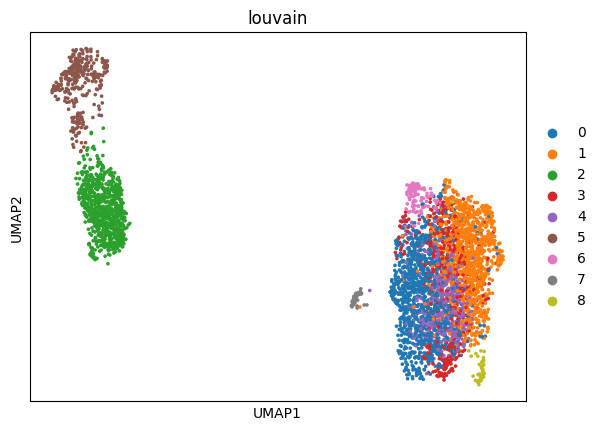

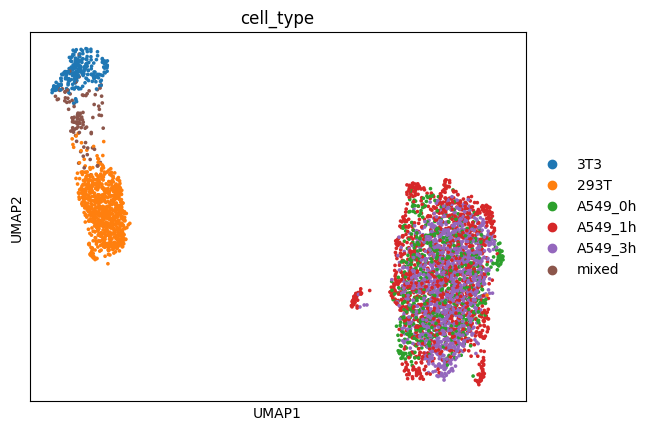

/root/miniconda3/envs/myconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


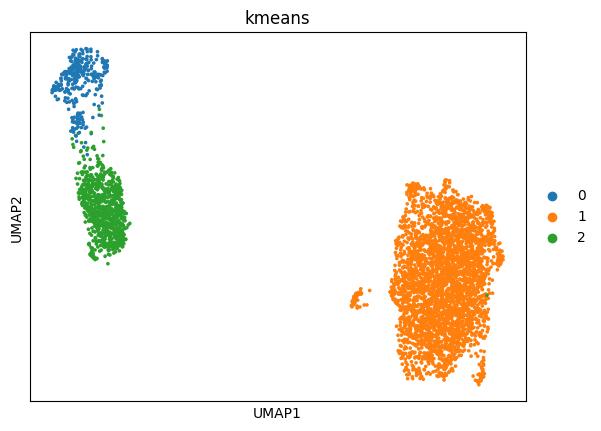

plot has been shown


In [12]:
# create posterior from trained model
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

# UMAP visulization
prior_adata = anndata.AnnData(X=latent)
cell_embeddings = pd.read_csv(input_path+'sciCAR_cell_annot.txt', sep="\t",index_col=0).iloc[:,[3,4,5]]
prior_adata.obs['cell_type'] = cell_embeddings.loc[dataset.barcodes,"labels"].to_list()
prior_adata.obsm["X_multi_vi"] = latent

# louvain cluster
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

# origin cell label
sc.pl.umap(prior_adata, color=['cell_type'])
plt.show()

# Kmeans cluster
from sklearn.cluster import KMeans
latent_code = prior_adata.obsm["X_multi_vi"]

kmeans = KMeans(n_clusters=3, random_state=0).fit(latent_code) 
prior_adata.obs['kmeans'] = kmeans.labels_.astype(str)
sc.pl.umap(prior_adata, color=['kmeans'])
plt.show()
print("plot has been shown")

In [14]:
# save all output to files
# 1. 20-diemension joint latent embedding of scMVP
df = pd.DataFrame(data=prior_adata.obsm["X_multi_vi"],  index=dataset.barcodes)
df.to_csv(os.path.join(output_path,"multivae_latent_imputation.csv"))

# 2. 2-diemension UMAP visualization
df = pd.DataFrame(data=prior_adata.obsm["X_umap"],  columns=["umap_dim1","umap_dim2"] , index=dataset.barcodes)
# add label columns
df.insert(0,"kmeans",prior_adata.obs['kmeans'].values)
df.to_csv(os.path.join(output_path,"multivae_umap.csv"))

# 3. whole scATAC imputations and scRNA imputations. It will took really long time if the scATAC dataset is very large.
df = pd.DataFrame(data=imputed_values[1].T, columns=dataset.barcodes, index=dataset.atac_names)
df.to_csv(os.path.join(output_path,"atac_multivae_imputation.csv"))

df = pd.DataFrame(data=imputed_values[0].T, columns=dataset.barcodes, index=dataset.gene_names)
df.to_csv(os.path.join(output_path,"gene_multivae_imputation.csv"))

## Step3: Perform differential analysis
Here, we demostrate two DE contrasts of A549_1h/A549_0h and A549_3h/A549_0h.   
You can change the DE groups as one cell type versus all other cell types.

In [15]:
# Differential gene analysis
posterior_adata = anndata.AnnData(X=imputed_values[0])
posterior_adata.var = pd.DataFrame(index=dataset.gene_names.reshape(-1))
posterior_adata.obsm["X_multi_vi"] = latent
posterior_adata.obs['cell_type'] =  cell_embeddings.loc[dataset.barcodes,"labels"].to_list()
sc.tl.rank_genes_groups(posterior_adata, 'cell_type', group=["A549_1h","A549_3h"],reference="A549_0h")
df_tab=sc.get.rank_genes_groups_df(posterior_adata, group=["A549_1h","A549_3h"])
df_tab.to_csv("{}/sciCAR_A549_DEG_tutorial.csv".format(output_path),index=False)

## (Optional) Pre-training
- For large and complex realistic joint profiling dataset like SHARE-seq skin dataset, we recommend to perform pre-training before scMVP training.

- We next give a demo for pretraining of scRNA and scATAC, and then perform scMVP training.

### Step1: Construct separate dataset obeject

In [16]:
atac_dataset = GeneExpressionDataset()
cell_attributes_dict = {
    "barcodes": dataset.barcodes
    }
atac_dataset.populate_from_data(
    X=dataset.atac_expression, # notice the normalization
    batch_indices=None,
    gene_names=dataset.atac_names,
    cell_attributes_dict=cell_attributes_dict,
    Ys=[],
)
rna_dataset = GeneExpressionDataset()
Ys = []
measurement = CellMeasurement(
        name="atac_expression",
        data=atac_dataset.X,
        columns_attr_name="atac_names",
        columns=atac_dataset.gene_names,
    )
Ys.append(measurement)
cell_attributes_dict = {
    "barcodes": dataset.barcodes
    }
rna_dataset.populate_from_data(
    X=dataset.X,
    batch_indices=None,
    gene_names=dataset.gene_names,
    cell_attributes_dict=cell_attributes_dict,
    Ys=Ys,
)

[2025-05-12 13:12:07,742] WARNING - scMVP.dataset.dataset | This dataset has some empty cells, this might fail scMVP inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2025-05-12 13:12:07,758] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2025-05-12 13:12:07,759] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2025-05-12 13:12:07,795] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2025-05-12 13:12:07,796] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]


### Step2: Pretrain and visualize ATAC dataset
(approximate 1min on 1080Ti)

In [17]:
# ATAC pretraining
start_time = time.time()
pre_atac_vae = VAE_Peak_SelfAttention(atac_dataset.nb_genes, n_latent=20,n_batch=0, n_layers=1, log_variational=True, reconstruction_loss="nb")
pre_atac_trainer = UnsupervisedTrainer(
    pre_atac_vae,
    atac_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

if os.path.isfile('%s/pre_atac_trainer_tutorial.pkl' % output_path):
    pre_atac_trainer.model.load_state_dict(torch.load('%s/pre_atac_trainer_tutorial.pkl' % output_path))
    pre_atac_trainer.model.eval()
else:
    pre_atac_trainer.train(n_epochs=15, lr=lr)
    torch.save(pre_atac_trainer.model.state_dict(), '%s/pre_atac_trainer_tutorial.pkl' % output_path)
    pre_atac_trainer.model.eval()

end_time = time.time()
# caculate training time
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds.")
# Training completed in 43.51 seconds.


training:   0%|          | 0/15 [00:00<?, ?it/s]reconst_loss=1970.621338, kl_divergence=0.096451
tensor(1971.6215, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2024.456055, kl_divergence=0.101645
tensor(2025.4562, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1936.730957, kl_divergence=0.124302
tensor(1937.7311, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1977.249878, kl_divergence=0.138879
tensor(1978.2500, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=1982.289062, kl_divergence=0.164145
tensor(1983.2891, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2153.318359, kl_divergence=0.180744
tensor(2154.3184, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2572.810547, kl_divergence=0.211174
tensor(2573.8105, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2335.427734, kl_divergence=0.235591
tensor(2336.4277, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2590.698730, kl_divergence=0.266387
tensor(2591.6990, device='cuda:0', grad

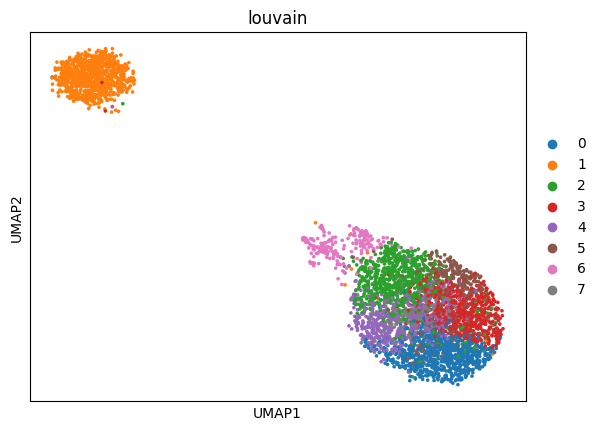

In [18]:
# ATAC pretrainer_posterior:
full = pre_atac_trainer.create_posterior(pre_atac_trainer.model, atac_dataset, indices=np.arange(len(atac_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
prior_adata = anndata.AnnData(X=atac_dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

### Step3: Perform similar pretraining for scRNA dataset
(less than 1min)

In [19]:
# RNA embedding
pre_vae = VAE_Attention(rna_dataset.nb_genes, n_latent=20,n_batch=0, n_layers=1, log_variational=True, reconstruction_loss="nb")
pre_trainer = UnsupervisedTrainer(
    pre_vae,
    rna_dataset,
    train_size=0.9,
    use_cuda=True,
    frequency=5,
)


if os.path.isfile('%s/pre_trainer_tutorial.pkl' % output_path):
    pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer_tutorial.pkl' % output_path))
    pre_trainer.model.eval()

else:
    pre_trainer.train(n_epochs=10, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/pre_trainer_tutorial.pkl' % output_path)
    pre_trainer.model.eval()


training:   0%|          | 0/10 [00:00<?, ?it/s]reconst_loss=1027.544800, kl_divergence=0.728608
tensor(1028.5448, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=814.783203, kl_divergence=0.730887
tensor(815.7833, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=929.969482, kl_divergence=0.833789
tensor(930.9695, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=956.732788, kl_divergence=0.930003
tensor(957.7328, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=847.085693, kl_divergence=1.041610
tensor(848.0857, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=879.552612, kl_divergence=1.203527
tensor(880.5526, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=834.082031, kl_divergence=1.324365
tensor(835.0820, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=773.457153, kl_divergence=1.343069
tensor(774.4572, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=753.710632, kl_divergence=1.342524
tensor(754.7106, device='cuda:0', grad_fn=<DivBackward

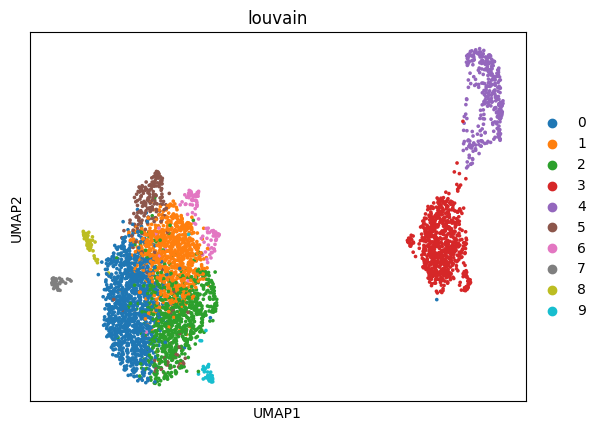

In [20]:
# RNA pretrainer_posterior:
full = pre_trainer.create_posterior(pre_trainer.model, rna_dataset, indices=np.arange(len(rna_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

# UMAP visulization
prior_adata = anndata.AnnData(X=rna_dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

### Step4:  Perform scMVP training with two pretrained models
(few minutes)

In [21]:
# get n_centroids from scRNA data
start_time = time.time()
n_centroids=len(np.unique(prior_adata.obs['louvain'].tolist()))


multi_vae = Multi_VAE_Attention(rna_dataset.nb_genes, len(rna_dataset.atac_names), n_batch=0, n_latent=20, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    rna_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)


if os.path.isfile('%s/multi_vae_trainer_tutorial2.pkl' % output_path):
    trainer.model.load_state_dict(torch.load('%s/multi_vae_trainer_tutorial2.pkl' % output_path))
    trainer.model.eval()
else:
    pre_trainer = UnsupervisedTrainer(
        pre_vae,
        rna_dataset,
        train_size=0.9,
        use_cuda=use_cuda,
        frequency=5,
    )
    pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer_tutorial.pkl' % output_path))

    pre_atac_trainer = UnsupervisedTrainer(
        pre_atac_vae,
        atac_dataset,
        train_size=0.9,
        use_cuda=use_cuda,
        frequency=5,
    )
    pre_atac_trainer.model.load_state_dict(torch.load('%s/pre_atac_trainer_tutorial.pkl' % output_path))

    n_centroids=len(np.unique(prior_adata.obs['louvain'].tolist()))

    # joint RNA and ATAC embedding
    trainer.model.init_gmm_params_with_louvain(latent,np.array(prior_adata.obs['louvain'].tolist()).astype(int))

    trainer.model.RNA_encoder.load_state_dict(pre_trainer.model.z_encoder.state_dict())
    for param in trainer.model.RNA_encoder.parameters():
        param.requires_grad = True
    trainer.model.ATAC_encoder.load_state_dict(pre_atac_trainer.model.z_encoder.state_dict())
    for param in trainer.model.ATAC_encoder.parameters():
        param.requires_grad = True
    trainer.train(n_epochs=15, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer_tutorial2.pkl' % output_path)
    trainer.model.eval()

end_time = time.time()
# caculate training time
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds.")
# Training completed in 100.42 seconds.

training:   0%|          | 0/15 [00:00<?, ?it/s]logpzc:-160.38999938964844, logqcx:-2.3025851249694824
kld_qz_pz = 120.575928,kld_qz_rna = 9321.586914,kld_qz_atac = 4906.947266,kl_divergence = 197.301880,reconst_loss_rna = 2702.817871,        reconst_loss_atac = 225.745575, mu=0.063578, sigma=0.934257
reconst_loss = 2985.253662,kl_divergence_local = 197.301880,kl_weight = 1.000000,loss = 3182.555664
tensor(3182.5557, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-95.97386932373047, logqcx:-2.3025851249694824
kld_qz_pz = 58.209427,kld_qz_rna = 9372.796875,kld_qz_atac = 3494.668945,kl_divergence = 79.318848,reconst_loss_rna = 2859.593750,        reconst_loss_atac = 220.463150, mu=0.063556, sigma=0.935214
reconst_loss = 3136.746826,kl_divergence_local = 79.318848,kl_weight = 1.000000,loss = 3216.065918
tensor(3216.0659, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-88.97660827636719, logqcx:-2.3025851249694824
kld_qz_pz = 52.207848,kld_qz_rna = 8497.105469,kld_qz_atac = 2795.789551,k

In [ ]:
#### Then same with direct scMVP training

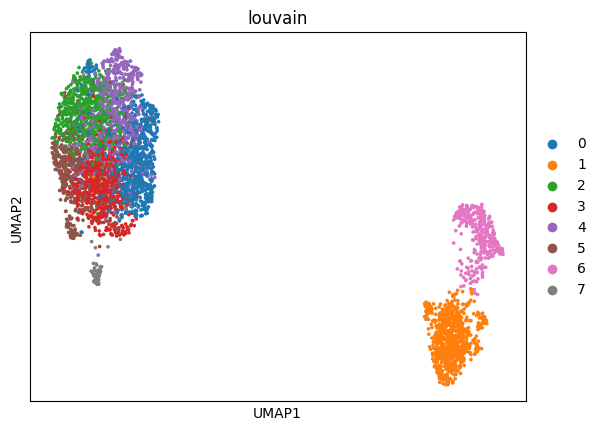

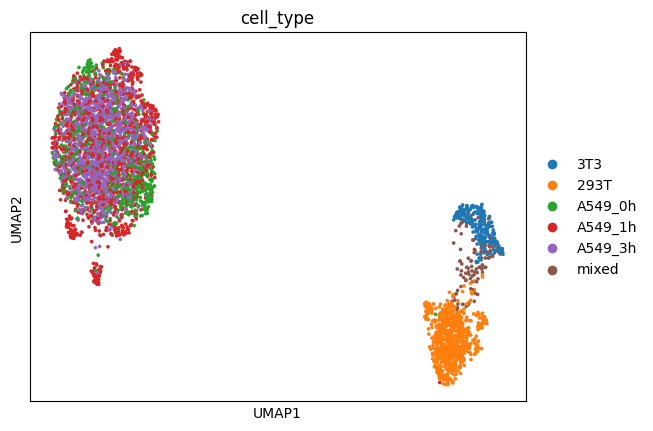

/root/miniconda3/envs/myconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


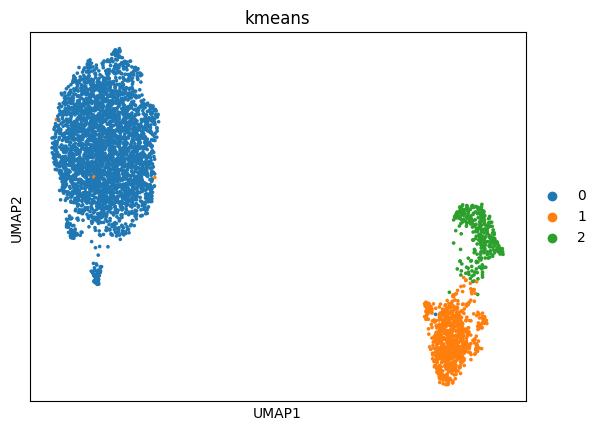

In [22]:
# create posterior from trained model
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

# UMAP visulization
prior_adata = anndata.AnnData(X=latent)
cell_embeddings = pd.read_csv(input_path+'sciCAR_cell_annot.txt', sep="\t",index_col=0).iloc[:,[3,4,5]]
prior_adata.obs['cell_type'] = cell_embeddings.loc[dataset.barcodes,"labels"].to_list()
prior_adata.obsm["X_multi_vi"] = latent

# louvain cluster
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

# origin cell label
sc.pl.umap(prior_adata, color=['cell_type'])
plt.show()

# Kmeans cluster
from sklearn.cluster import KMeans
latent_code = prior_adata.obsm["X_multi_vi"]

kmeans = KMeans(n_clusters=3, random_state=0).fit(latent_code) 
prior_adata.obs['kmeans'] = kmeans.labels_.astype(str)
sc.pl.umap(prior_adata, color=['kmeans'])
plt.show()